Connect the libraries

In [ ]:
import os
import re
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.transforms as tt
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.utils as vutils

import cv2
import cv2 as cv
from google.colab.patches import cv2_imshow

from PIL import Image
from pathlib import Path

from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

Let's turn to the Google drive in which the dataset is located

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Dataset

Download and process the dataset [fruit](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection).

In [ ]:
root = '/content/gdrive/MyDrive/data'

# the get_data function outputs an array of image names and the corresponding key
def get_data(root):
    data = []
    target = []

    photos = os.listdir(root)
    for photo in photos:
        if photo.endswith('jpg'):
            data.append(photo)
        if photo.endswith('xml'):
            target.append(photo)

    x_label = []
    y_label = []

    for photo_d in data:
        x_label.append(photo_d)
        crop_d = photo_d.split('.')[0]
        for photo_t in target:
            crop_t = photo_t.split('.')[0]
            if crop_t == crop_d:
                y_label.append(photo_t)

    return x_label, y_label

# the spliter and get_box functions get the class label and bbox coordinates
def spliter(line):
    line = re.split(">", line)
    line = re.split("<", line[1])
    return(line[0])

def get_box(root_t, batch_indices, y_label):
    box = open(root_t + '/' + y_label[batch_indices], 'r')

    image_boxes = []

    for element in box:
        if "<name>" in element:
            image_boxes.append(spliter(element))
        if "<xmin>" in element:
            image_boxes.append(int(spliter(element)))
        if "<ymin>" in element:
            image_boxes.append(int(spliter(element)))
        if "<xmax>" in element:
            image_boxes.append(int(spliter(element)))
        if "<ymax>" in element:
            image_boxes.append(int(spliter(element)))

    return image_boxes

# the Resize function translates the dimensions of the bbox after resizing the image
def Resize(image_boxes, size_old, size_new):
    image_boxes_new = [0 for k in range(len(image_boxes))]
    num_box = len(image_boxes) // 5
    #size_old = img.shape (Hight, Width)
    for k in range(num_box):
        image_boxes_new[0+k*5] = image_boxes[0+k*5]
        image_boxes_new[1+k*5] = float(image_boxes[1+k*5])*float(size_new[1])/float(size_old[1])
        image_boxes_new[2+k*5] = float(image_boxes[2+k*5])*float(size_new[0])/float(size_old[0])
        image_boxes_new[3+k*5] = float(image_boxes[3+k*5])*float(size_new[1])/float(size_old[1])
        image_boxes_new[4+k*5] = float(image_boxes[4+k*5])*float(size_new[0])/float(size_old[0])

    return image_boxes_new

# the Horizontal_flip function translates the dimensions of the bbox after the horizontal flip of the image
def Horizontal_flip(image_boxes, size):
    image_boxes_new = [0 for k in range(len(image_boxes))]
    num_box = len(image_boxes) // 5

    for k in range(num_box):
        image_boxes_new[0+k*5] = image_boxes[0+k*5]
        image_boxes_new[1+k*5] = size[1]-image_boxes[3+k*5]
        image_boxes_new[2+k*5] = image_boxes[2+k*5]
        image_boxes_new[3+k*5] = size[1]-image_boxes[1+k*5]
        image_boxes_new[4+k*5] = image_boxes[4+k*5]

    return image_boxes_new

# the Verical_flip function translates the dimensions of the bbox after a vertical flip of the image
def Verical_flip(image_boxes, size):
    image_boxes_new = [0 for k in range(len(image_boxes))]
    num_box = len(image_boxes) // 5

    for k in range(num_box):
        image_boxes_new[0+k*5] = image_boxes[0+k*5]
        image_boxes_new[1+k*5] = image_boxes[1+k*5]
        image_boxes_new[2+k*5] = size[0]-image_boxes[4+k*5]
        image_boxes_new[3+k*5] = image_boxes[3+k*5]
        image_boxes_new[4+k*5] = size[0]-image_boxes[2+k*5]

    return image_boxes_new

# the get_dict function gets the dictionary from the bbox
def get_dict(image_boxes, device):
    d = {}
    num_box = len(image_boxes) // 5
    labels = torch.zeros([num_box]).to(device)
    boxes = torch.zeros([num_box, 4]).to(device)

    for k in range(num_box):

        if image_boxes[0+k*5] == 'apple':
            labels[k] = 1
        elif image_boxes[0+k*5] == 'orange':
            labels[k] = 2
        elif image_boxes[0+k*5] == 'banana':
            labels[k] = 3

        boxes[k] = torch.from_numpy(np.array(image_boxes[1+k*5:5+k*5])).double().to(device)

    d['boxes'] = boxes
    d['labels'] = labels.long()

    return d

In [ ]:
x_label, y_label = get_data(root + '/' + 'train')

print(len(x_label))
print(len(y_label))

240
240


In [ ]:
# the get_dataloader function outputs a random batch (image with augmentation + box) from the Google dock,
# in which the dataset is loaded
def get_dataloader(image_size, batch_size, root, train_or_test, device):

    if train_or_test == 'train':
        root_t = root + '/' + 'train'
    elif train_or_test == 'test':
        root_t= root + '/' + 'test'
    else:
        print('train or test')

    x_label, y_label = get_data(root_t)
    indices = [i for i in range(len(x_label))]
    random.shuffle(indices)
    n = len(x_label)

    for start in range(0, n, batch_size):
        # in the end, we may need to take an incomplete butch
        end = min(start + batch_size, n)

        batch_indices = indices[start:end]
        x_batch = []
        y_batch = []

        for i in range(len(batch_indices)):

            img = cv.imread(os.path.join(root_t, x_label[batch_indices[i]]))
            size_old = img.shape # (Hight, Width))
            img = cv.resize(img, image_size)
            size_new = img.shape

            image_boxes = get_box(root_t, batch_indices[i], y_label)
            image_boxes = Resize(image_boxes, size_old, size_new)

            ran_1 = random.random()
            image_boxes_H = []
            if ran_1 > 0.5:
                # Horizontal Flip
                img = cv2.flip(img, 1)
                image_boxes_H = Horizontal_flip(image_boxes, size_new)

            if len(image_boxes_H) != 0:
                for j in range(len(image_boxes)):
                    image_boxes[j] = image_boxes_H[j]

            ran_2 = random.random()
            image_boxes_W = []
            if ran_2 > 0.5:
                # Verical Flip
                img = cv2.flip(img, 0)
                image_boxes_W = Verical_flip(image_boxes, size_new)

            if len(image_boxes_W) != 0:
                for j in range(len(image_boxes)):
                    image_boxes[j] = image_boxes_W[j]

            dict_one = get_dict(image_boxes, device)

            x_batch.append(torch.from_numpy(img/255).permute(2,0,1).float().to(device))
            y_batch.append(dict_one)

        yield x_batch, y_batch

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
image_size = (256, 256) # the size to which we will bring all the images of the dataset
batch_size = 8
num_epochs = 30
train_dl = get_dataloader(image_size, batch_size, root, 'train', device)

In [ ]:
train_dl = get_dataloader(image_size, batch_size, root, 'train', device)
for x, y in train_dl:
    break

Let's look at the images and bbox of our dataset

In [ ]:
# the draw function draws a picture from a bbox
def draw(x, y):
    img = (x.permute(1,2,0).cpu()).numpy()*255
    num_bbox = y['boxes'].shape[0]

    for i in range(num_bbox):

        if y['labels'][i] == 1:
            text = 'apple'
        if y['labels'][i] == 2:
            text = 'orange'
        if y['labels'][i] == 3:
            text = 'banana'

        start_point = (y['boxes'][i][0], y['boxes'][i][1])
        end_point = (y['boxes'][i][2], y['boxes'][i][3])
        img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), 2)
        img = cv2.putText(img, text, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    fig = figsize=(14, 14)
    cv2_imshow(img)

# the draw function draws a picture with the predicted bbox
def draw_pred(x, target, pred):
    img = (x.permute(1,2,0).cpu()).numpy()*255
    num_bbox = target['boxes'].shape[0]

    for i in range(num_bbox):

        if target['labels'][i] == 1:
            text_target = 'apple'
        if target['labels'][i] == 2:
            text_target = 'orange'
        if target['labels'][i] == 3:
            text_target = 'banana'

        if pred['labels'][i] == 1:
            text_pred = 'apple'
        if pred['labels'][i] == 2:
            text_pred = 'orange'
        if pred['labels'][i] == 3:
            text_pred = 'banana'

        start_point_target = (target['boxes'][i][0], target['boxes'][i][1])
        end_point_target = (target['boxes'][i][2], target['boxes'][i][3])

        start_point_pred = (pred['boxes'][i][0], pred['boxes'][i][1])
        end_point_pred = (pred['boxes'][i][2], pred['boxes'][i][3])

        img = cv2.rectangle(img, start_point_target, end_point_target, (255, 0, 0), 2)
        img = cv2.putText(img, text_target, start_point_target, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        img = cv2.rectangle(img, start_point_pred, end_point_pred, (0, 255, 0), 2)
        img = cv2.putText(img, text_pred, start_point_pred, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    fig = figsize=(14, 14)
    cv2_imshow(img)

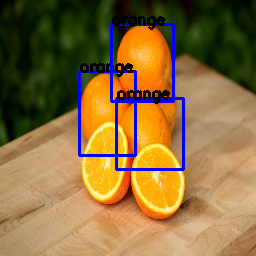

In [ ]:
exemple = 0
draw(x[exemple], y[exemple])

# Metric

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

For example, let's look at the truth (left) and prediction (right):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then the intersection and union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_metric(box_1, box_2):
    # box_1 - target
    # box_2 - pridict
    x1_max = max(box_1[0], box_2[0])
    x2_min = min(box_1[2], box_2[2])
    y1_max = max(box_1[1], box_2[1])
    y2_min = min(box_1[3], box_2[3])

    S_1 = (box_1[2]-box_1[0])*(box_1[3]-box_1[1])
    S_2 = (box_2[2]-box_2[0])*(box_2[3]-box_2[1])
    dS = (x2_min-x1_max)*(y2_min-y1_max)

    return (dS)/(S_1+S_2-dS)

We will consider accuracy, if pred and target match, then we consider the metric IoU

In [ ]:
def metric(pred, target):
    iou = 0
    accuracy = 0
    amount = 0
    for i in range(len(target)):
        num_box = target[i]['boxes'].shape[0]

        for j in range(num_box):
            amount += 1
            if pred[i]['labels'][j] == target[i]['labels'][j]:
                accuracy += 1
                iou = iou + iou_metric(target[i]['boxes'][j], pred[i]['boxes'][j])

    return accuracy/amount, iou / amount

# Model

Connecting the pre-trained model fasterrcnn_resnet50_fpn

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import  FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4
num_bbox = model.roi_heads.box_predictor.bbox_pred.out_features
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
def train(batch_size, optimizer, scheduler):
    scheduler.step()
    model.train()
    running_loss = 0
    train_dataloader = get_dataloader(image_size, batch_size, root, 'train', device)
    for x, y in train_dataloader:

        optimizer.zero_grad()
        loss_dict = model(x, y)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()  

    train_loss = running_loss/batch_size
    return train_loss

def evalute(batch_size):
    model.eval()
    iou_epoch = 0
    accuracy_epoch = 0
    n_epoch = 0

    val_dataloader = get_dataloader(image_size, batch_size, root, 'test', device)
    for x, y in val_dataloader:
        n_epoch += 1
        pred = model(x, y)
        accuracy_val, iou_val = metric(pred, y)

        accuracy_epoch += accuracy_val
        iou_epoch += iou_val

        torch.cuda.empty_cache()

    return accuracy_epoch / n_epoch, iou_epoch / n_epoch

In [ ]:
def save_model():
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/project/model/fasterrcnn_resnet50_fpn.pth')

model = model.to(device)

In [ ]:
num_epochs = 60
learning_rate = 0.5*1e-4
optim = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_sch = lr_scheduler.StepLR(optim, step_size=15, gamma=0.1)

In [ ]:
history_train = []
history_accuracy = []
history_iou = []

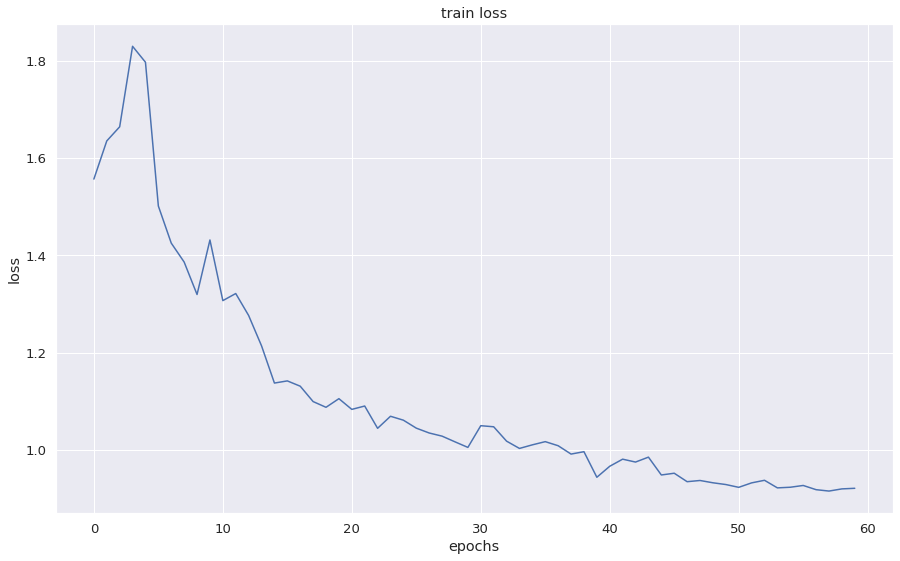

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(history_train)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

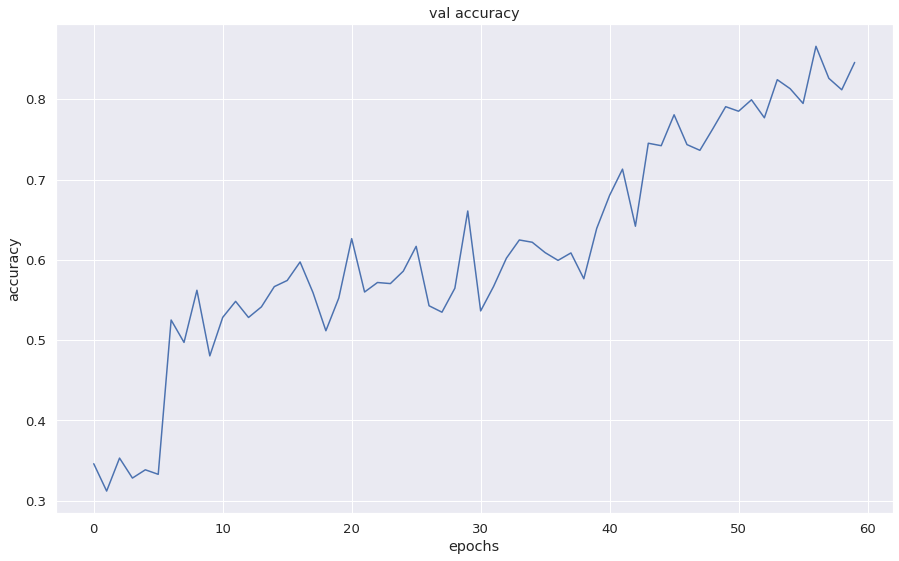

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(history_accuracy)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('val accuracy')
plt.show()

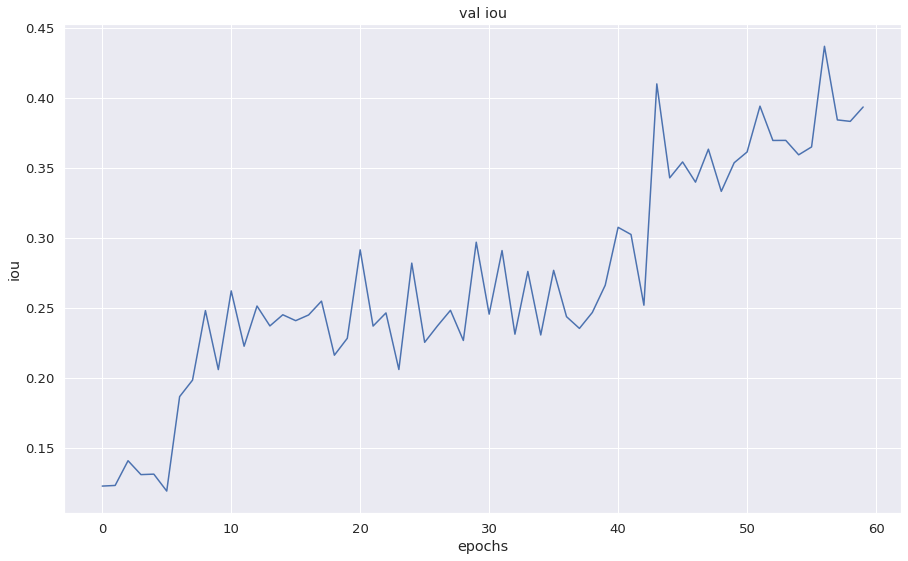

In [ ]:
for i in range(len(history_iou)):
    history_iou[i] = history_iou[i].cpu()
    
plt.figure(figsize=(15, 9))
plt.plot(history_iou)
plt.xlabel('epochs')
plt.ylabel('iou')
plt.title('val iou')
plt.show()

Let's calculate the F1 score on the test data

In [ ]:
data_pred = []
data_target = []
train_dl = get_dataloader(image_size, batch_size, root, 'test', device)
for x, y in train_dl:
    with torch.no_grad():
        pred = model(x, y)
    for i in range(len(y)):
        for j in range(y[i]['labels'].shape[0]):
            data_target.append(y[i]['labels'][j].item())
            data_pred.append(pred[i]['labels'][j].item())

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(data_target, data_pred, average='weighted')
print('F1 score = ', f1)

F1 score =  0.8745587745587745


Let's look at an example of a predicted bbox

In [ ]:
train_dl = get_dataloader(image_size, batch_size, root, 'test', device)
for x, y in train_dl:
    break

In [ ]:
model.eval()
predictions = model(x)

IoU =  tensor(0.8504, device='cuda:0', grad_fn=<AddBackward0>)


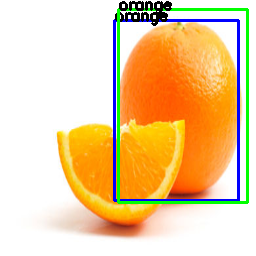

In [ ]:
exemple = 2

IoU = 0
for i in range(y[exemple]['boxes'].shape[0]):
    IoU = IoU + iou_metric(y[exemple]['boxes'][i], predictions[exemple]['boxes'][i])

print('IoU = ', IoU)

draw_pred(x[exemple], y[exemple], predictions[exemple])

Green - prediction

Синий - target

This model may be useful in fruit picking in the future. For example, an artificial intelligence (robot) will be created that will automatically collect fruits in the garden, using cameras to see this model in order to fix fruits that can be collected.